|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -25.1     | 0.9722    | 0.05177   | 4.35      | 6.237     | 205.0     | 0.6842    | 0.1034    | 0.8727    |
| 2         | -23.84    | 0.641     | 0.07781   | 8.549     | 6.647     | 160.9     | 0.9635    | 0.8971    | 0.5984    |
| 3         | -29.62    | 0.798     | 0.0616    | 7.935     | 9.363     | 62.81     | 0.1348    | 0.117     | 0.6824    |
| 4         | -24.16    | 0.9017    | 0.09732   | 5.331     | 5.306     | 94.73     | 0.9025    | 0.7636    | 0.5994    |
| 5         | -24.14    | 0.6828    | 0.0636    | 3.281     | 8.422     | 210.1     | 0.01914   | 0.806     | 0.7024    |
| 6         | -24.79    | 0.5018    | 0.05187   | 5.358     | 5.819     | 284.2     | 0.8766    | 0.7521    | 0.7325    |
| 7         | -27.68    

| 37        | -30.45    | 0.5       | 0.1       | 10.0      | 1.0       | 171.9     | 1.0       | 1.0       | 0.5       |
| 38        | -36.37    | 0.5       | 0.1       | 6.632     | 1.0       | 185.7     | 0.0       | 0.0       | 1.0       |
| 39        | -25.0     | 1.0       | 0.1       | 10.0      | 10.0      | 91.05     | 1.0       | 1.0       | 0.5       |
| 40        | -24.71    | 1.0       | 0.1       | 3.0       | 10.0      | 260.1     | 0.0       | 1.0       | 0.5       |
| 41        | -26.8     | 0.5       | 0.1       | 10.0      | 10.0      | 266.8     | 1.0       | 1.0       | 0.5       |
| 42        | -25.43    | 0.5       | 0.1       | 10.0      | 10.0      | 212.0     | 0.0       | 0.0       | 1.0       |
| 43        | -53.19    | 0.5       | 0.01      | 9.048     | 10.0      | 221.5     | 1.0       | 1.0       | 0.5       |
| 44        | -27.08    | 0.5       | 0.1       | 3.812     | 10.0      | 152.5     | 1.0       | 1.0       | 0.5       |
| 45        | -27.16    

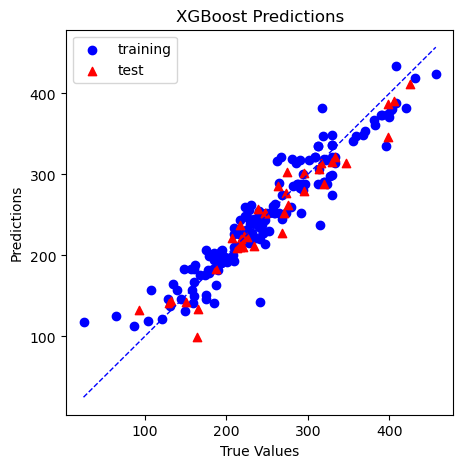

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from bayes_opt import BayesianOptimization

# 读取数据
data = pd.read_excel('UTS.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=73)

# 定义目标函数
def xgb_evaluate(learning_rate, n_estimators, max_depth, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(x_train, y_train)
    predictions = xgb_model.predict(x_test)
    mse = mean_squared_error(y_test, predictions)
    return -np.sqrt(mse)

# 定义超参数范围
param_bounds = {
    'learning_rate': (0.01, 0.1),
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0, 1),       # L1 正则化
    'reg_lambda': (0, 1)       # L2 正则化
}

# 进行贝叶斯优化
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=37,
    verbose=2
)
optimizer.maximize(init_points=20, n_iter=50)

# 获取最佳参数
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

# 输出最佳参数
print("Best parameters found by Bayesian Optimization:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# 使用最佳参数训练最终模型
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(x_train, y_train)

# 评价模型
xgb_MSE = mean_squared_error(y_train, xgb_model.predict(x_train))
xgb_RMSE = np.sqrt(xgb_MSE)
xgb_R2 = r2_score(y_train, xgb_model.predict(x_train))
print('RMSE_train: ' + str(xgb_RMSE))
print('R2_train: ' + str(xgb_R2))

xgb_MSE_t = mean_squared_error(y_test, xgb_model.predict(x_test))
xgb_RMSE_t = np.sqrt(xgb_MSE_t)
xgb_R2_t = r2_score(y_test, xgb_model.predict(x_test))
print('RMSE_test: ' + str(xgb_RMSE_t))
print('R2_test: ' + str(xgb_R2_t))

# 可视化结果
plt.figure(figsize=(5, 5))
plt.scatter(y_train, xgb_model.predict(x_train), c="blue", label='training')
plt.scatter(y_test, xgb_model.predict(x_test), c='red', label='test', marker='^')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'b--', lw=1)
plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('XGBoost Predictions')
plt.show()


RMSE_train: 20.704984290950772
R2_train: 0.9325582725721034
RMSE_test: 22.2860866733806
R2_test: 0.9169596313674162


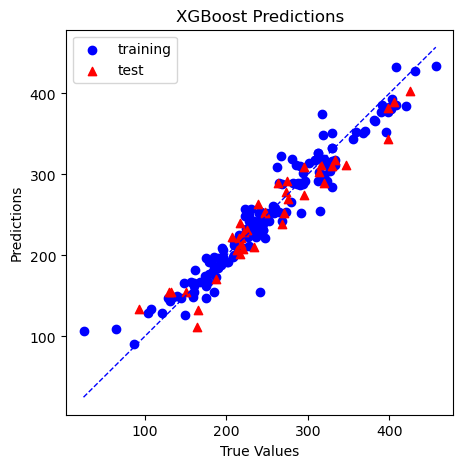

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

# 读取数据
data = pd.read_excel('UTS.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=73)

# 最佳参数
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5.411729501146951,
    'n_estimators': 139,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'subsample': 0.5,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# 使用最佳参数训练最终模型
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(x_train, y_train)

# 评价模型
xgb_MSE = mean_squared_error(y_train, xgb_model.predict(x_train))
xgb_RMSE = np.sqrt(xgb_MSE)
xgb_R2 = r2_score(y_train, xgb_model.predict(x_train))
print('RMSE_train: ' + str(xgb_RMSE))
print('R2_train: ' + str(xgb_R2))

xgb_MSE_t = mean_squared_error(y_test, xgb_model.predict(x_test))
xgb_RMSE_t = np.sqrt(xgb_MSE_t)
xgb_R2_t = r2_score(y_test, xgb_model.predict(x_test))
print('RMSE_test: ' + str(xgb_RMSE_t))
print('R2_test: ' + str(xgb_R2_t))

# 准备导出数据
train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': xgb_model.predict(x_train),
    'Type': 'Train'
})
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': xgb_model.predict(x_test),
    'Type': 'Test'
})
results = pd.concat([train_results, test_results])

# 导出到Excel文件
results.to_excel('nzutsxgboost_predictions.xlsx', index=False)

# 可视化结果
plt.figure(figsize=(5, 5))
plt.scatter(y_train, xgb_model.predict(x_train), c="blue", label='training')
plt.scatter(y_test, xgb_model.predict(x_test), c='red', label='test', marker='^')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'b--', lw=1)
plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('XGBoost Predictions')
plt.show()


In [11]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb

warnings.filterwarnings("ignore")

# 读取数据
data = pd.read_excel('UTS.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=37)

# 确保特征维度
print(f"x_train shape: {x_train.shape}")  # 输出训练集特征的形状

# 最佳参数
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5.584623189803611,
    'n_estimators': 166,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample': 0.8681395618115305,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# 使用最佳参数训练最终模型
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(x_train, y_train)

# 计算样本集中值
def compute_central_location(X):
    return np.mean(X, axis=0)

# 计算左右偏度
def compute_skewness(X, CL):
    N_L = np.sum(X < CL, axis=0)
    N_U = np.sum(X > CL, axis=0)
    skewness_L = N_L / (N_L + N_U + 1)
    skewness_U = N_U / (N_L + N_U + 1)
    return skewness_L, skewness_U

# 计算不对称接受域范围
def compute_asymmetric_range(X, CL, skewness_L, skewness_U):
    LB = CL - (1 / skewness_U) * (CL - np.min(X, axis=0))
    UB = CL + (1 / skewness_L) * (np.max(X, axis=0) - CL)
    return LB, UB

# PSO算法生成虚拟输入特征
def generate_virtual_samples(X, num_samples=100, num_particles=30, num_iterations=100):
    CL = compute_central_location(X)
    skewness_L, skewness_U = compute_skewness(X, CL)
    LB, UB = compute_asymmetric_range(X, CL, skewness_L, skewness_U)
    
    all_samples = []
    
    while len(all_samples) < num_samples:
        particles = np.random.uniform(LB, UB, (num_particles, X.shape[1]))
        velocities = np.zeros_like(particles)
        personal_best = particles.copy()
        global_best = particles[np.argmin(np.std(particles, axis=1))]

        for _ in range(num_iterations):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities = 0.7 * velocities + 1.5 * r1 * (personal_best - particles) + 1.5 * r2 * (global_best - particles)
            particles = particles + velocities
            particles = np.clip(particles, LB, UB)
            particles = np.clip(particles, 0, None)  # 确保所有特征值为正
            
            current_best = particles[np.argmin(np.std(particles, axis=1))]
            if np.std(current_best) < np.std(global_best):
                global_best = current_best

        for particle in particles:
            if len(all_samples) < num_samples and not any(np.array_equal(particle, s) for s in all_samples):
                all_samples.append(particle)
    
    virtual_samples = np.array(all_samples)
    print(f"Generated virtual samples shape: {virtual_samples.shape}")  # 调试信息
    return virtual_samples

# 预测虚拟样本的输出标签
def predict_output_labels(model, virtual_features):
    return model.predict(virtual_features)

# 生成虚拟输入特征
virtual_features = generate_virtual_samples(x_train.values, num_samples=100)  # 更改此处的 num_samples 参数值即可

# 确保虚拟输入特征的形状与训练集特征形状一致
assert virtual_features.shape[1] == x_train.shape[1], "虚拟样本的特征维度与训练集特征维度不一致！"

# 预测虚拟样本的输出标签
virtual_labels = predict_output_labels(xgb_model, virtual_features)

# 打印生成的虚拟样本
print("生成的虚拟样本（输入特征）：\n", virtual_features)
print("生成的虚拟样本（输出标签）：\n", virtual_labels)

# 将虚拟样本数据导出到Excel
virtual_data = pd.DataFrame(virtual_features, columns=X.columns)
virtual_data['Predicted_Output'] = virtual_labels
virtual_data.to_excel('virtual_samples.xlsx', index=False)
print("虚拟样本数据已导出到 virtual_samples.xlsx")


x_train shape: (152, 9)
Generated virtual samples shape: (100, 9)
生成的虚拟样本（输入特征）：
 [[0.00000000e+00 4.96809189e-01 5.07910102e+00 0.00000000e+00
  5.82657467e-01 0.00000000e+00 0.00000000e+00 1.23521277e-01
  4.95772675e+01]
 [8.26770347e+00 1.50343026e+01 5.15380583e+00 9.02937065e-02
  8.34463486e-02 9.02960535e-02 6.32241215e-01 4.54181402e-01
  1.00843653e+02]
 [8.62406714e+00 1.40781075e+01 3.30553142e+00 1.75289378e-01
  4.62862000e-01 9.37236587e-02 0.00000000e+00 0.00000000e+00
  4.72805485e+01]
 [0.00000000e+00 9.03683374e+00 3.31537086e+00 8.35819436e-02
  7.90509550e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.38319472e+01]
 [2.51822605e+01 9.66784686e+00 3.45195986e+00 1.47041308e-01
  4.15444297e-01 5.35783757e-01 3.23177994e-01 1.44878713e-01
  8.47506884e+01]
 [0.00000000e+00 2.20128251e+00 3.27127697e+00 0.00000000e+00
  8.69080780e-01 7.45739571e-01 2.48930632e-01 2.57263563e-01
  1.06359100e+02]
 [3.19901838e+01 1.09738296e+00 4.06669800e+00 4.32673547e-01
  2.

RMSE_train: 20.704984290950772
R2_train: 0.9325582725721034
RMSE_test: 22.2860866733806
R2_test: 0.9169596313674162


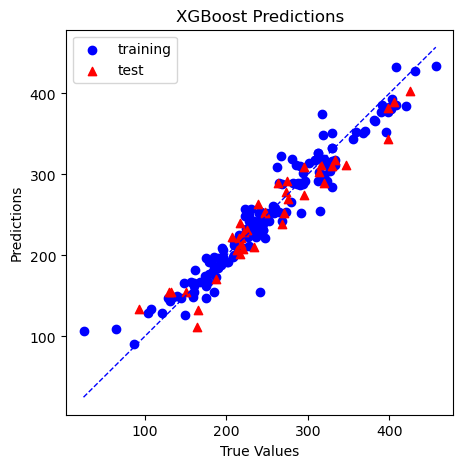

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

# 读取数据
data = pd.read_excel('UTS.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=73)

# 最佳参数
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5.411729501146951,
    'n_estimators': 139,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'subsample': 0.5,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# 使用最佳参数训练最终模型
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(x_train, y_train)

# 评价模型
xgb_MSE = mean_squared_error(y_train, xgb_model.predict(x_train))
xgb_RMSE = np.sqrt(xgb_MSE)
xgb_R2 = r2_score(y_train, xgb_model.predict(x_train))
print('RMSE_train: ' + str(xgb_RMSE))
print('R2_train: ' + str(xgb_R2))

xgb_MSE_t = mean_squared_error(y_test, xgb_model.predict(x_test))
xgb_RMSE_t = np.sqrt(xgb_MSE_t)
xgb_R2_t = r2_score(y_test, xgb_model.predict(x_test))
print('RMSE_test: ' + str(xgb_RMSE_t))
print('R2_test: ' + str(xgb_R2_t))

# 准备导出数据
train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': xgb_model.predict(x_train),
    'Type': 'Train'
})
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': xgb_model.predict(x_test),
    'Type': 'Test'
})
results = pd.concat([train_results, test_results])

# 导出到Excel文件
results.to_excel('nzutsxgboost_predictions.xlsx', index=False)

# 可视化结果
plt.figure(figsize=(5, 5))
plt.scatter(y_train, xgb_model.predict(x_train), c="blue", label='training')
plt.scatter(y_test, xgb_model.predict(x_test), c='red', label='test', marker='^')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'b--', lw=1)
plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('XGBoost Predictions')
plt.show()